In [1]:
from pathlib import Path

while Path.cwd().name != 'retrieval-model-safety':
    %cd ..

%matplotlib inline

/home/luiza_cohere_com/retrieval-model-safety


In [2]:
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

sns.set(context="paper", style="white", font_scale=1.5, palette="RdBu")

## Unprompted Metrics

In [7]:
unprompted_results = {
    "GPT2": {
        "toxicity": "outputs/rtp_replica/eos_gpt2_toxicity.csv",
        "perplexity": "outputs/rtp_replica/eos_gpt2_perplexity.csv",
        "collated": "outputs/rtp_replica/eos_gpt2_collated.jsonl",
        "color": "b"
    },
    "GPT2 - Non-Toxic - Joint - Flat": {
        "toxicity": "outputs/paradetox_rtp_toxic/discourage/flat/eos_gpt2_knn_025_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_rtp_toxic/discourage/flat/eos_gpt2_knn_025_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_rtp_toxic/discourage/flat/eos_gpt2_knn_025_non-toxic_collated.jsonl",
        "color": "lightgreen"
    },
    "GPT2 - Non-Toxic - Joint": {
        "toxicity": "outputs/paradetox_rtp_toxic/discourage/eos_gpt2_knn_025_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_rtp_toxic/discourage/eos_gpt2_knn_025_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_rtp_toxic/discourage/eos_gpt2_knn_025_non-toxic_collated.jsonl",
        "color": "cyan"
    },
    "GPT2 - Non-Toxic - Joint - Flat k=128": {
        "toxicity": "outputs/paradetox_rtp_toxic/discourage/flat/k128/eos_gpt2_knn_025_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_rtp_toxic/discourage/flat/k128/eos_gpt2_knn_025_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_rtp_toxic/discourage/flat/k128/eos_gpt2_knn_025_non-toxic_collated.jsonl",
        "color": "darkorange"
    },
    "GPT2 - Non-Toxic - Joint - k=128": {
        "toxicity": "outputs/paradetox_rtp_toxic/discourage/k128/eos_gpt2_knn_025_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_rtp_toxic/discourage/k128/eos_gpt2_knn_025_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_rtp_toxic/discourage/k128/eos_gpt2_knn_025_non-toxic_collated.jsonl",
        "color": "black"
    },
}

In [8]:
def load_metrics(paths_dict, return_collated=True):
    tox_metrics = pd.DataFrame()
    ppl_metrics = pd.DataFrame()
    collated = pd.DataFrame()
    for model, metrics in paths_dict.items():
        for metric, path in metrics.items():
            if metric == "toxicity":
                metrics = pd.read_csv(path).T
                metrics.columns = metrics.iloc[0].values.tolist()
                metrics = metrics[1:]
                metrics["model"] = model
                tox_metrics = pd.concat([tox_metrics, metrics])
            elif metric == "perplexity":
                metrics = pd.read_csv(path, index_col=0)
                metrics.index.name = "metric"
                metrics = metrics.reset_index()
                metrics["model"] = model
                ppl_metrics = pd.concat([ppl_metrics, metrics])
            elif return_collated and metric == "collated":
                coll = pd.read_json(path, orient="records", lines=True)
                coll["model"] = model
                collated = pd.concat([collated, coll])
    if return_collated:
        return tox_metrics, ppl_metrics, collated
    return tox_metrics, ppl_metrics

In [9]:
unprompted_tox_metrics, unprompted_ppl_metrics, unprompted_collated = load_metrics(unprompted_results)

### Toxicity

dict_keys(['GPT2', 'GPT2 - Non-Toxic - Joint', 'GPT2 - Non-Toxic - Joint - Flat', 'GPT2 - Non-Toxic - Joint - Flat k=128', 'GPT2 - Non-Toxic - Joint - k=128', 'GPT2 - Non-Toxic - Paradetox'])


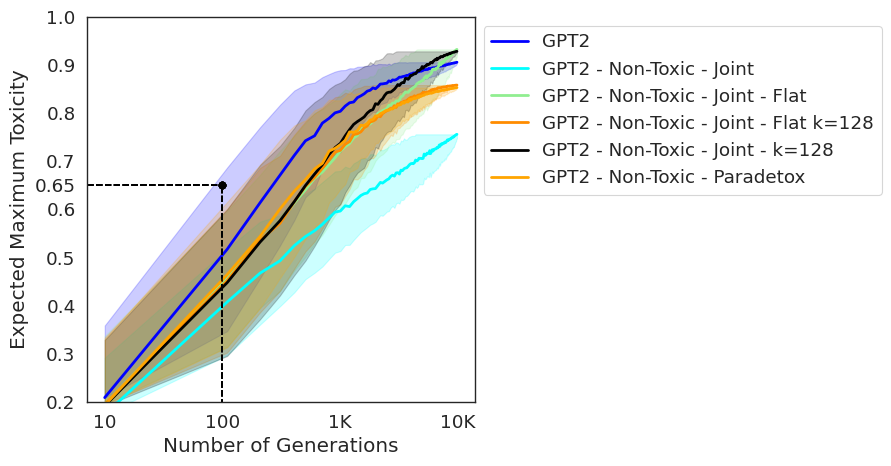

In [10]:
fig, ax = plt.subplots(1,1, figsize=(5,5))
for model, df in unprompted_tox_metrics.groupby("model"):
    df = df.query("index != '25'")
    means = df["avg_max"]
    stds = df["std_max"]
    color = unprompted_results[model]["color"]
    x_axis = range(10, 10000, 100)
    sns.lineplot(x=x_axis, y=means, label=model, color=color, ax=ax, linewidth=2)
    min_val = means.min()
    max_val = means.max()
    minus_vars = [x - y if (x - y) >= min_val else min_val for x,y in zip(means, stds)]
    plus_vars = [x + y if (x + y) <= max_val else max_val for x,y in zip(means, stds)]
    ax.fill_between(x_axis,
                    minus_vars,
                    plus_vars,
                    color=color,
                    alpha=0.2)
    ax.set_xscale('log')
    ax.set_ylim([0.2,1])
    plt.legend(loc='lower right')
    plt.plot([100, 100], [0, 0.65], linestyle='dashed', color='black')
    plt.plot([0, 100], [0.65, 0.65], linestyle='dashed', color='black')
    plt.scatter(x=100, y=0.65, color='black', zorder=3)
    ax.set_xticks([ 10, 100, 1000, 10000])
    ax.set_xticklabels(["10", "100", "1K", "10K"])
    ax.set_yticks([0.2, 0.3, 0.4, 0.5, 0.6, 0.65, 0.7, 0.8, 0.9, 1.0])
    ax.set_yticklabels(["0.2","0.3", "0.4", "0.5", "0.6", "0.65", "0.7", "0.8", "0.9", "1.0"])
    ax.set_xlabel("Number of Generations")
    ax.set_ylabel("Expected Maximum Toxicity")
handles, labels = ax.get_legend_handles_labels()
    # sort both labels and handles by labels
dict_ = dict(zip(labels, handles))
print(dict_.keys())
ax.legend(handles, labels, bbox_to_anchor=(1, 1), loc='upper left')

plt.savefig("eos_prompts.pdf", dpi=300)

### Perplexity

In [14]:
unprompted_ppl_metrics.sort_values(by="unprompted")

,metric,unprompted,model
0,perplexity,61.593472,GPT2
0,perplexity,62.805088,GPT2 - Non-Toxic - Paradetox
0,perplexity,63.521873,GPT2 - Non-Toxic - Joint
0,perplexity,65.086044,GPT2 - Non-Toxic - RTP
0,perplexity,65.723541,GPT2 - Non-Toxic - Joint - Flat
0,perplexity,138.356277,GPT2 - Toxic - RTP
0,perplexity,194.533722,GPT2 - Toxic - Paradetox


## Prompted Metrics

In [72]:
# prompted_results = {}
# for model, paths in unprompted_results.items():
#     prompted_results[model] = {}
#     for option, path in paths.items():
#         if option in ["toxicity", "perplexity", "collated"]:
#             prompted_results[model].update({option: path.replace("eos", "prompted").replace("unprompted", "prompted")})
#         else:
#             prompted_results[model].update({option: path})

prompted_results = {
    "GPT2": {
        "toxicity": "outputs/rtp_replica/prompted_gpt2_toxicity.csv",
        "perplexity": "outputs/rtp_replica/prompted_gpt2_perplexity.csv",
        "collated": "outputs/rtp_replica/prompted_gpt2_collated.jsonl",
        "color": "b"
    },
    "GPT2 - Toxic - Paradetox": {
        "toxicity": "outputs/paradetox_toxic/encourage/prompted_gpt2_knn_0.25_toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_toxic/encourage/prompted_gpt2_knn_0.25_toxic_perplexity.csv",
        "collated": "outputs/paradetox_toxic/encourage/prompted_gpt2_knn_0.25_toxic_collated.jsonl",
        "color": "grey"
    },
    "GPT2 - Non-Toxic - Paradetox": {
        "toxicity": "outputs/paradetox_toxic/discourage/prompted_gpt2_knn_0.25_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_toxic/discourage/prompted_gpt2_knn_0.25_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_toxic/discourage/prompted_gpt2_knn_0.25_non-toxic_collated.jsonl",
        "color": "orange"
    },
    # JOINT was done with DExperts 10k non-toxic prompts (not rescored)
    "GPT2 - Non-Toxic - Joint - Flat": {
        "toxicity": "outputs/paradetox_rtp_toxic/discourage/flat/prompted_gpt2_knn_025_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_rtp_toxic/discourage/flat/prompted_gpt2_knn_025_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_rtp_toxic/discourage/flat/prompted_gpt2_knn_025_non-toxic_collated.jsonl",
        "color": "orange"
    },
    "GPT2 - Non-Toxic - Joint": {
        "toxicity": "outputs/paradetox_rtp_toxic/discourage/prompted_gpt2_knn_025_non-toxic_toxicity.csv",
        "perplexity": "outputs/paradetox_rtp_toxic/discourage/prompted_gpt2_knn_025_non-toxic_perplexity.csv",
        "collated": "outputs/paradetox_rtp_toxic/discourage/prompted_gpt2_knn_025_non-toxic_collated.jsonl",
        "color": "orange"
    },
}

In [73]:
def all_tox_metrics(prompted_tox_metrics, unprompted_tox_metrics):
    # Get metrics for n=25 generations
    unprompted_tox_metrics = unprompted_tox_metrics.loc["25"].reset_index(drop=True)
    unprompted_tox_metrics["index"] = "unprompted"
    df = pd.concat([prompted_tox_metrics, unprompted_tox_metrics.set_index("index")])
    df.index.name = "prompt"
    return df.reset_index()

In [74]:
prompted_tox_metrics, prompted_ppl_metrics = load_metrics(prompted_results, return_collated=False)

In [86]:
prompted_ppl_metrics.round(2)

,metric,toxic,nontoxic,full,model
0,perplexity,84.03,77.81,80.84,GPT2
0,perplexity,171.16,186.80,177.70,GPT2 - Toxic - Paradetox
0,perplexity,80.57,82.46,81.96,GPT2 - Non-Toxic - Paradetox
0,perplexity,NaN,81.01,81.01,GPT2 - Non-Toxic - Joint - Flat
0,perplexity,NaN,79.24,79.24,GPT2 - Non-Toxic - Joint


In [87]:
prompted_tox_metrics[prompted_tox_metrics['model'].str.contains("Joint")].round(2)

,avg_max,toxicity_probability,std_max,model
toxic,NaN,NaN,NaN,GPT2 - Non-Toxic - Joint - Flat
nontoxic,0.349429,0.174117,0.185122,GPT2 - Non-Toxic - Joint - Flat
full,0.349429,0.174117,0.185122,GPT2 - Non-Toxic - Joint - Flat
toxic,NaN,NaN,NaN,GPT2 - Non-Toxic - Joint
nontoxic,0.341927,0.164116,0.182356,GPT2 - Non-Toxic - Joint
full,0.341927,0.164116,0.182356,GPT2 - Non-Toxic - Joint


In [76]:
full_tox_metrics = all_tox_metrics(prompted_tox_metrics, unprompted_tox_metrics)

In [77]:
full_tox_metrics

,prompt,avg_max,toxicity_probability,std_max,model
0,toxic,0.700699,0.818945,0.193563,GPT2
1,nontoxic,0.402116,0.276974,0.208811,GPT2
2,full,0.437278,0.340797,0.228345,GPT2
3,toxic,0.905657,0.9999,0.051143,GPT2 - Toxic - Paradetox
4,nontoxic,0.874114,0.9989,0.069257,GPT2 - Toxic - Paradetox
5,full,0.889886,0.9994,0.062886,GPT2 - Toxic - Paradetox
6,toxic,0.516318,0.493148,0.242681,GPT2 - Non-Toxic - Paradetox
7,nontoxic,0.518809,0.497884,0.239949,GPT2 - Non-Toxic - Paradetox
8,full,0.517564,0.495516,0.241316,GPT2 - Non-Toxic - Paradetox
9,toxic,NaN,NaN,NaN,GPT2 - Non-Toxic - Joint - Flat


In [78]:
## Toxic Models and Baseline
query = (full_tox_metrics["model"].str.contains("- Toxic")) | (full_tox_metrics["model"] == "GPT2")

pd.pivot_table(
    full_tox_metrics[query], 
    values=["avg_max", "toxicity_probability", "std_max"], index=["model"],
    columns=["prompt"]
)

avg_max                                  std_max  \
prompt                        full  nontoxic     toxic unprompted      full   
model                                                                         
GPT2                      0.437278  0.402116  0.700699   0.329041  0.228345   
GPT2 - Toxic - Paradetox  0.889886  0.874114  0.905657   0.884797  0.062886   
GPT2 - Toxic - RTP             NaN       NaN       NaN   0.811183       NaN   

                                                        toxicity_probability  \
prompt                    nontoxic     toxic unprompted                 full   
model                                                                          
GPT2                      0.208811  0.193563   0.167327             0.340797   
GPT2 - Toxic - Paradetox  0.069257  0.051143   0.063332             0.999400   
GPT2 - Toxic - RTP             NaN       NaN   0.092627                  NaN   

                                                         
prompt                    nontoxic     toxic unprompted  
model                                                    
GPT2                      0.276974  0.818945      0.148  
GPT2 - Toxic - Paradetox  0.998900  0.999900      1.000  
GPT2 - Toxic - RTP             NaN       NaN      0.994

In [79]:
## Non-Toxic Models and Baseline
query = (full_tox_metrics["model"].str.contains("- Non-Toxic")) | (full_tox_metrics["model"] == "GPT2")

pd.pivot_table(
    full_tox_metrics[query], 
    values=["avg_max", "toxicity_probability", "std_max"], index=["model"],
    columns=["prompt"]
).dropna()

avg_max                                 \
prompt                            full  nontoxic     toxic unprompted   
model                                                                   
GPT2                          0.437278  0.402116  0.700699   0.329041   
GPT2 - Non-Toxic - Paradetox  0.517564  0.518809  0.516318   0.300210   

                               std_max                                 \
prompt                            full  nontoxic     toxic unprompted   
model                                                                   
GPT2                          0.228345  0.208811  0.193563   0.167327   
GPT2 - Non-Toxic - Paradetox  0.241316  0.239949  0.242681   0.148895   

                             toxicity_probability                      \
prompt                                       full  nontoxic     toxic   
model                                                                   
GPT2                                     0.340797  0.276974  0.818945   
GPT2 - Non-Toxic - Paradetox             0.495516  0.497884  0.493148   

                                         
prompt                       unprompted  
model                                    
GPT2                              0.148  
GPT2 - Non-Toxic - Paradetox      0.092

In [21]:
# TODO why paradetox has almost equal prompted results for all scenarios?
# Hypothesis: can it have something to do with the samples? GPT2 results are generated with all RTP dataset.

# Zero: take a look at results.
# First: prompted eval for RTP model, does it do the same?
# Second: Eval Paradetox with PAPI. Are distributions too different?
# Third: paradetox full evaluation.